In [187]:
# Imports 
import redis
import time
import timeit
import seaborn as sns
import pandas as pd

In [188]:
# Store client passed modification time in a hash called MY_KEYSMTIME
mtime_get="""
local keys_mtime_hset = "MY_KEYSMTIME"
local key = KEYS[1]
local mtime = tonumber(ARGV[1])

local key_mtime = redis.call('HGET', keys_mtime_hset, key)
key_mtime = tonumber(key_mtime)
-- if missing key in the hash set return the value of the key.
-- or key mtime > mtime 
if not key_mtime or key_mtime > mtime then
    return redis.call('GET', key)
end

return nil    
"""

mtime_set="""
local keys_mtime_hset = "MY_KEYSMTIME"
local key = KEYS[1]
local value = ARGV[1]
local mtime = tonumber(ARGV[2])

redis.call('SET', key, value)
redis.call('HSET', keys_mtime_hset, key, mtime)
"""


m1 = int(time.time())
r = redis.Redis(host='localhost', port=6379)
MTGET=r.register_script(mtime_get)
MTSET=r.register_script(mtime_set)

t_k = "Hello"
t_v = "World"

r.delete(t_k)

print(MTGET(keys=[t_k], args=[m1]))

print(MTSET(keys=[t_k], args=[t_v, m1]))

print(r.get(t_k))

print(MTGET(keys=[t_k], args=[m1 - 100]))

print(MTGET(keys=[t_k], args=[m1 + 100]))


None
None
b'World'
b'World'
None


In [189]:
# Run and plot a simple benchmark
REPEAT=10000
NUMBER=3

g = timeit.Timer("r.get(t_k)",globals=globals())
timings_get = g.repeat(repeat=REPEAT, number=NUMBER)

g = timeit.Timer("MTGET(keys=[t_k], args=[m1 - 100])",globals=globals())
timings_hits_mtget = g.repeat(repeat=REPEAT, number=NUMBER)

g = timeit.Timer("MTGET(keys=[t_k], args=[m1 + 100])",globals=globals())
timings_miss_mtget = g.repeat(repeat=REPEAT, number=NUMBER)

df = pd.DataFrame.from_dict({'get': timing_plain_keys, 'mtget hits': timing_hits_mtget, 'mtget misses': timing_misses_mtget})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   get           5000 non-null   float64
 1   mtget hits    5000 non-null   float64
 2   mtget misses  5000 non-null   float64
dtypes: float64(3)
memory usage: 117.3 KB


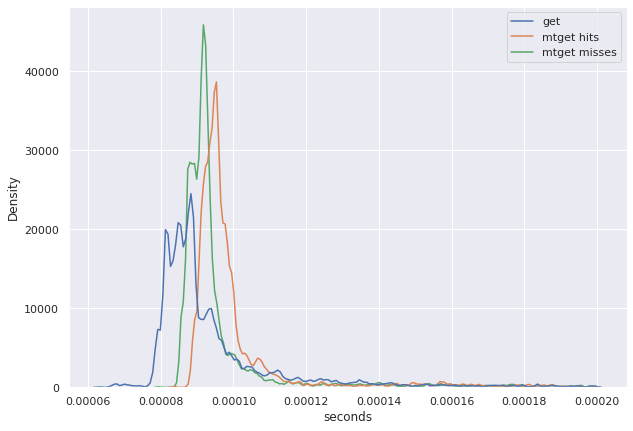

In [190]:
sns.set_theme(style="darkgrid")

kp = sns.kdeplot(data=df[df < 0.0002], bw_adjust=.15)
kp.set_xlabel("seconds")
kp.figure.set_figheight(7)
kp.figure.set_figwidth(10)

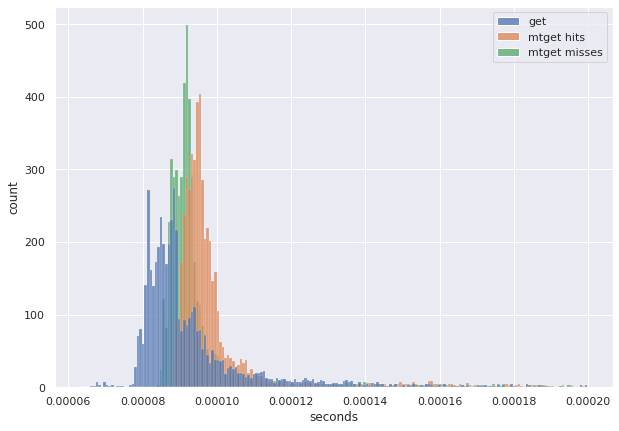

In [191]:
kp = sns.histplot(data=df[df < 0.0002], multiple='stack')
kp.set_xlabel("seconds")
kp.set_ylabel("count")
kp.figure.set_figheight(7)
kp.figure.set_figwidth(10)
